In [251]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import scipy.stats as st

import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")
%matplotlib inline

from sklearn.preprocessing import LabelEncoder

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [252]:
# Apply pretty styles
from IPython.core.display import HTML

def css_styling():
    styles = open("custom.css", "r").read()
    return HTML(styles)
css_styling()

# Load/clean the data 

In [253]:
data = pd.read_csv('train.csv')
# Display some useful info.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


# Diversity of the titanic population

Instead of taking a morbid approach to the problem right away, I am first going to look at the diversity of the titanic population before the tragedy (assuming the training set contained a representative sample of the whole population). To do this, I am first going to clean up the data a bit based on a few simplifying assumptions:
- LastName can be used as a proxy for Sibling/Parents / Removed SibSp, Parch
- PassengerId does not bring any useful info / Removed
- Fare and Pclass are redundant / Fare Removed
- Ticket does not bring interesting insight / Removed
- Cabin is mostly uncomplete / Removed

In [258]:
# Remove Cabin/Passenger Id
removed_col = ['Cabin','PassengerId','SibSp','Parch','Fare','Ticket']
df = data[[f for f in data.columns if f not in removed_col]].dropna()
# extract LastName
df['LastName'] = df.Name.map(lambda x:x.split(',')[0])
df = df.drop('Name',axis=1)
# convert Age as int
df['Age'] = [f for f in map(lambda x:int(x),df.Age)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 0 to 890
Data columns (total 6 columns):
Survived    712 non-null int64
Pclass      712 non-null int64
Sex         712 non-null object
Age         712 non-null int64
Embarked    712 non-null object
LastName    712 non-null object
dtypes: int64(3), object(3)
memory usage: 38.9+ KB


Let's also encode Sex,Embarked and LastName as integer to ease further processing using the labelEncoder class of sklearn.

In [259]:
# lsex - female:1,male:0
lsex = LabelEncoder().fit(df.Sex)
# lembarked - Cherbourg:0, Queenstown:1, Southampton:2 
lembarked = LabelEncoder().fit(df.Embarked)
llastname = LabelEncoder().fit(df.LastName)

df.loc[:,'Sex'] = lsex.transform(df.Sex)
df.loc[:,'Embarked'] = lembarked.transform(df.Embarked)
df.loc[:,'LastName'] = llastname.transform(df.LastName)

## General info 

In [260]:
df.describe()

,Survived,Pclass,Sex,Age,Embarked,LastName
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,0.404494,2.240169,0.636236,29.622191,1.595506,259.028090
std,0.491139,0.836854,0.481420,14.502891,0.779038,154.159358
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,20.000000,2.000000,126.750000
50%,0.000000,2.000000,1.000000,28.000000,2.000000,255.000000
75%,1.000000,3.000000,1.000000,38.000000,2.000000,390.250000
max,1.000000,3.000000,1.000000,80.000000,2.000000,532.000000


- The data is composed of 712 record.
- From the training set participant, about 40% died in the incident .. 67% died so our dataset is biased toward survival !
- Most of people were from 3rd class
- More men that women were present on board
- The age ranges from 0 to 80 years old with a mean around 30 years old.
- Most people embarked in Southampton.
- We cannot tell much about the LastName at this point..

## What is the passenger age distribution ?

Let's begin by drawing the normalized age distribution of the passenger (in the train set..)
- It is bimodal with one mode around baby/kids and another one around 30 years old. 
- It also display a thick slowly decreasing tail up to 80 years old

A few hypotheses able to explain this distribution could be 
- 1) old rich people contributes to the heavy tail
- 2) families contributes to the first mode and second mode
- 3) lonely travellers (mostly male ?) contributes to the second mode.

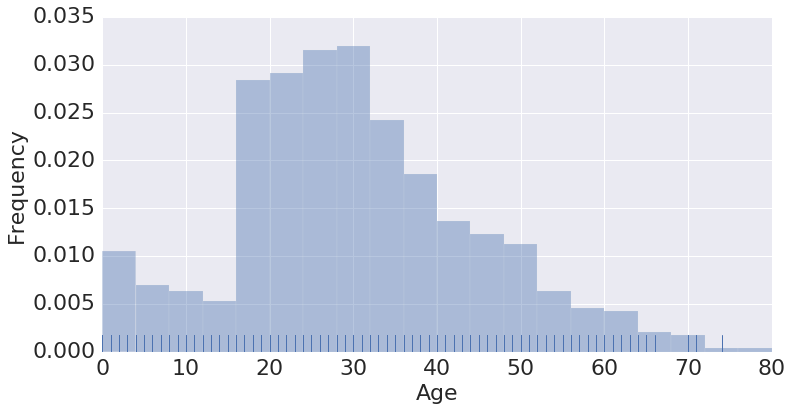

In [292]:
fig = plt.figure(figsize=(12,6))
ax = plt.subplot()
sns.distplot(df.Age,rug=True,kde=False,ax=ax,norm_hist=True)
ax.tick_params(labelsize=22)
ax.set_xlabel('Age',fontsize=22)
ax.set_ylabel('Frequency',fontsize=22)

To confirm these hypotheses, let's look at the distribution of age by passenger class. This is a reasonably good proxy for socio economic factor. 

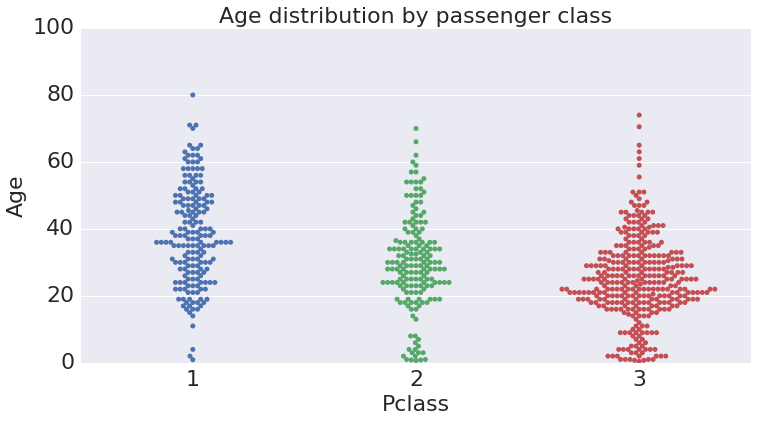

In [293]:
import seaborn as sns
fig = plt.figure(figsize=(12,6))
ax = plt.subplot(111)
# Draw a swarm plot summarizing the distribution for each passenger class independently.
sns.swarmplot(x="Pclass", y="Age", data=data,ax=ax,
               orient='v',split=True)
sns.despine(left=True)
ax.set_ylim(0,100)
ax.tick_params(labelsize=22)
ax.set_ylabel('Age',fontsize=22)
ax.set_xlabel('Pclass',fontsize=22)
ax.set_title('Age distribution by passenger class',fontsize=22)

In [263]:
df.groupby('Pclass').Age.mean()

Pclass
1    38.097826
2    29.855491
3    25.115493
Name: Age, dtype: float64

As expected 
- Rich people (1st class) contribute a lot to the tail of the distribution.
- Young people were mostly 3rd class passengers.
- Kids, the first mode of the age distrib., comes mainly from families in the 3rd and 2nd class. 

At this point we cannot really draw any conclusion on family Vs lonely travellers. Let's take a deeper look to the lonely traveller population. We can isolate them using a slightly oversimplifying  assumption, here it is:
- Group people by their last name and assume that people on board that are uniquely identified by this one are alone !

## Lonely travellers

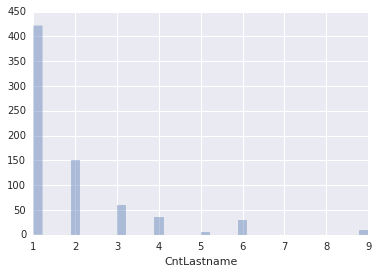

In [264]:
cnt = df.groupby('LastName').size().to_dict()
df['CntLastname'] = [f for f in map(lambda x:cnt[x], df.LastName)]
#ax = (data.CntLastname).hist(figsize=(16,8))
sns.distplot(df.CntLastname,kde=False)
ax.tick_params(labelsize=22)
ax.set_xlim(1,9)
ax.set_xlabel('Nb of persons appearing with a specific last name',fontsize=22)
ax.set_ylabel('Count',fontsize=22)

In [268]:
df.groupby('CntLastname').size()/len(df)

CntLastname
1    0.592697
2    0.210674
3    0.084270
4    0.050562
5    0.007022
6    0.042135
9    0.012640
dtype: float64

Lonely travellers represent 60% of the whole training set ... Let's not forget about the data we are working with here, 700 records out of 2500 passengers on the titanic. We are certainly missing parents/sibling from the rest of the titanic population. 

That said, let's nevertheless stick with our first assumption that the train set is representative of the whole population.

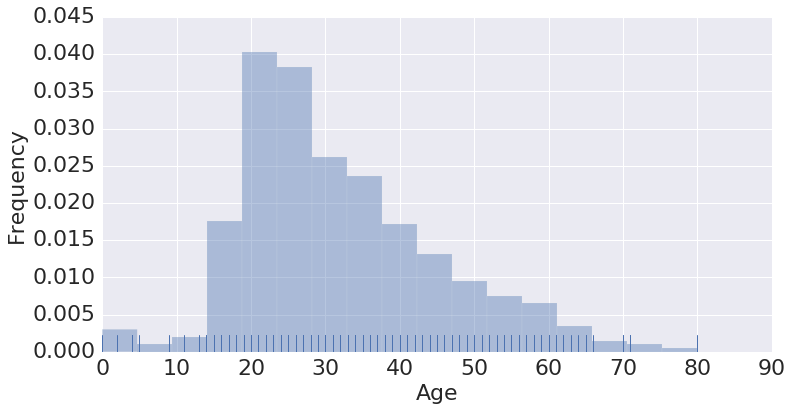

In [269]:
lonely = df[df.CntLastname==1]
fig = plt.figure(figsize=(12,6))
ax = plt.subplot()
sns.distplot(lonely.Age,rug=True,kde=False,ax=ax,norm_hist=True)
ax.tick_params(labelsize=22)
ax.set_xlabel('Age',fontsize=22)
ax.set_ylabel('Frequency',fontsize=22)

The age distribution looks now much more unimodal (expect a few babies). From there, we can ask several things:
- Where does these people comes from ?
- Are they rich ?
- Are they mostly men ?

Seaborn offers a nice way to explore the first two question in one plot.

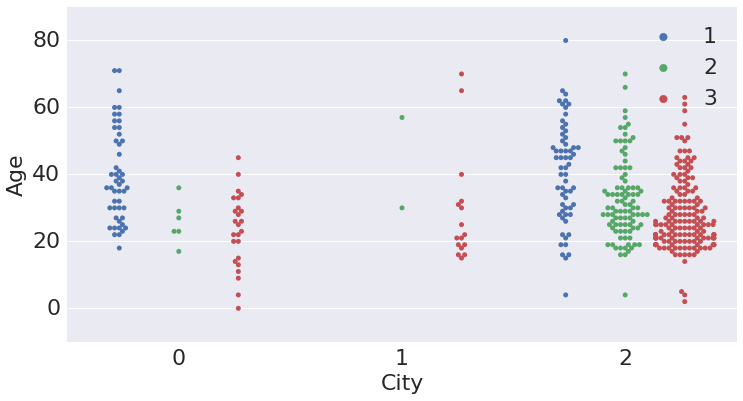

In [270]:
fig = plt.figure(figsize=(12,6))
ax = plt.subplot()
sns.swarmplot(x="Embarked", y="Age",hue='Pclass',data=lonely,split=True)
ax.tick_params(labelsize=22)
ax.legend(fontsize=22)
ax.set_xlabel('City',fontsize=22)
ax.set_ylabel('Age',fontsize=22)

In [271]:
lembarked.inverse_transform([0,1,2])

array(['C', 'Q', 'S'], dtype=object)

In [277]:
#0 is female, 1 is male
# % from the whole pop
lonely.groupby('Sex').size()/len(lonely)

Sex
0    0.303318
1    0.696682
dtype: float64

Answer : they mostly are 3rd class men (ratio ~2:3) passengers (not very rich) travelling from Southampton. My guess is that they were travelling toward the American Dream before this iceberg blew all their dreams at once.

How did they perform at the survival game ?

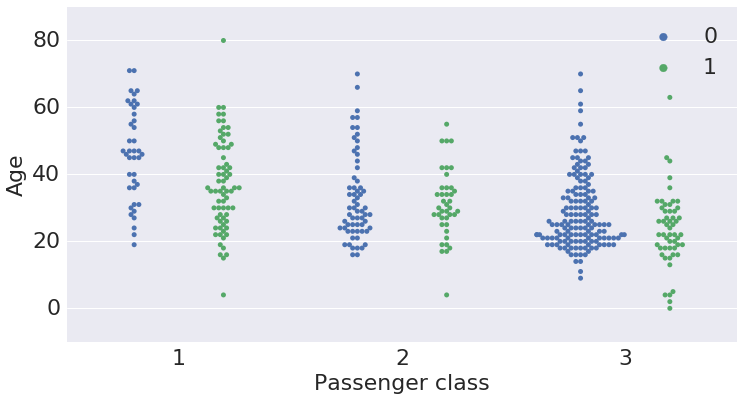

In [278]:
fig = plt.figure(figsize=(12,6))
ax = plt.subplot()
# sarmplot / Ideal to have an idea of the distrib/nb of data points
sns.swarmplot(x="Pclass", y="Age",hue='Survived',data=lonely,split=True)
ax.tick_params(labelsize=22)
ax.legend(fontsize=22)
ax.set_xlabel('Passenger class',fontsize=22)
ax.set_ylabel('Age',fontsize=22)

Not too good, especially for the young fellows in the third class. Not that, as expected, passenger less than 10 years old were saved during the tragedy.

Let's look at the survival rate by Age.  

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]),
 <a list of 63 Text xticklabel objects>)

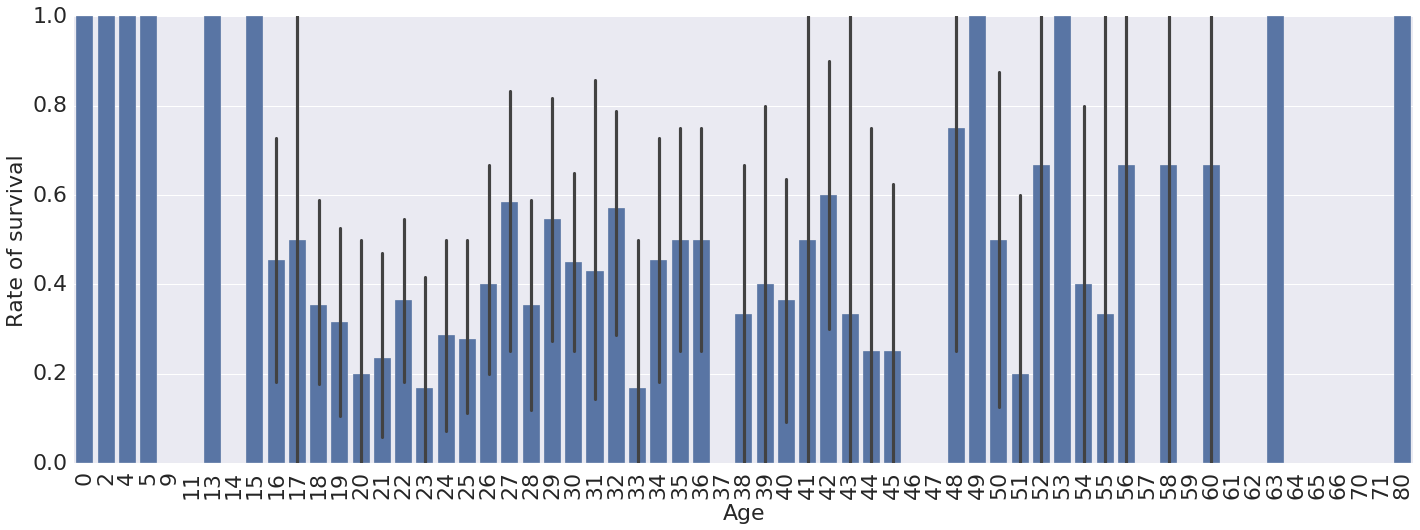

In [286]:
fig = plt.figure(figsize=(24,8))
ax = plt.subplot()
sns.barplot(x="Age", y="Survived", data=lonely,ax=ax,ci=95,color=sns.color_palette('deep')[0])
ax.set_ylabel('Rate of survival',fontsize=22)
ax.set_xlabel('Age',fontsize=22)
ax.tick_params(labelsize=22)
plt.xticks(rotation=90)

As expected.
- The likelihood of survival is large (~1) for, again "lonely", kids younger than 15 and passenger older than 50. 
- It drops substancially in between. In addition, this is biased toward larger values due to the relatively high survival rate of the 1st class passenger. If we remove them from the pool, it got worst...

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53]), <a list of 54 Text xticklabel objects>)

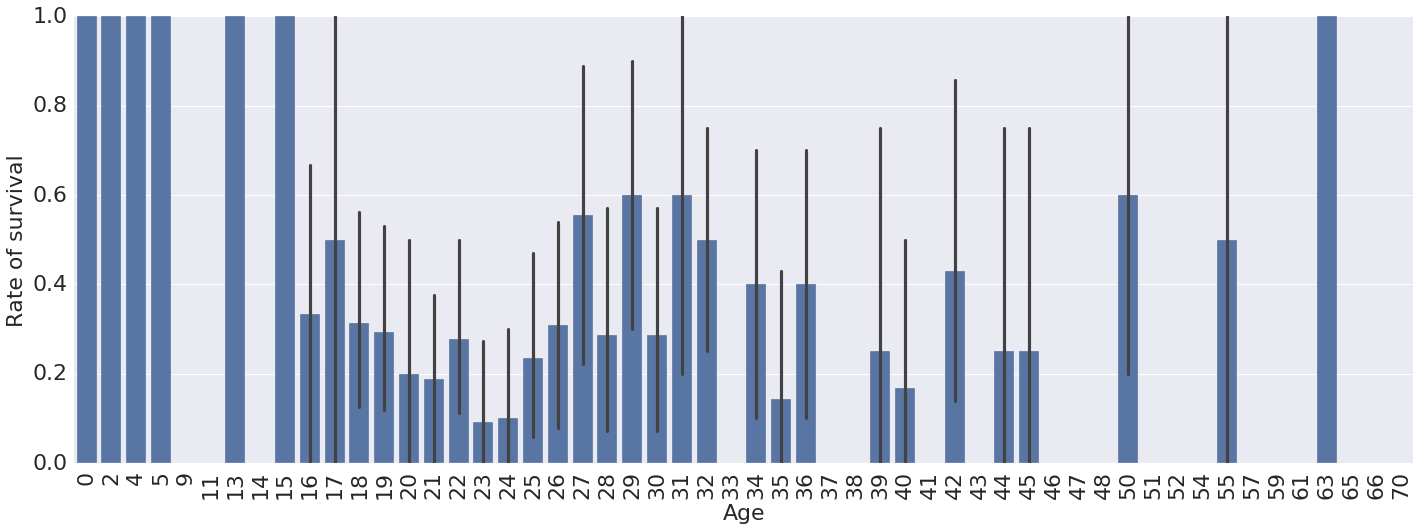

In [287]:
fig = plt.figure(figsize=(24,8))
ax = plt.subplot()
sns.barplot(x="Age", y="Survived", data=lonely[lonely.Pclass.isin([2,3])],
            ax=ax,ci=95,color=sns.color_palette('deep')[0])
ax.set_ylabel('Rate of survival',fontsize=22)
ax.set_xlabel('Age',fontsize=22)
ax.tick_params(labelsize=22)
plt.xticks(rotation=90)

Less than 30% of the people between 20 and 26 years old survived the disaster.

## Rapid modelling 

To finish this  exploration, let's try to do a simple logistic regression based on the age, class, city and lastnamecount on board. Given these regressors, we might already be able to get a good score on the leaderboard with a simple linear model !

In [288]:
import statsmodels.api as sm

In [289]:
model = sm.Logit(lonely['Survived'], lonely[['Age','Pclass','Embarked','CntLastname']])
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.588730
         Iterations 5


In [290]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  422
Model:                          Logit   Df Residuals:                      418
Method:                           MLE   Df Model:                            3
Date:                Fri, 09 Sep 2016   Pseudo R-squ.:                  0.1174
Time:                        14:46:24   Log-Likelihood:                -248.44
converged:                       True   LL-Null:                       -281.49
                                        LLR p-value:                 2.922e-14
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Age            -0.0372      0.009     -3.928      0.000        -0.056    -0.019
Pclass         -1.0155      0.154     -6.589      0.000        -1.318    -0.713
Embarked       -0.2921      0.138     -2.113    

It appears that a simple logistic regression does not have a lot of predictive power for this dataset. The pseudo R-squared is very small and the hability of this model to explain the survival rate is not much better than a model without any regressors... 

Still, it suggests an interesting fact:

- Given a specific lastname, the other variable being constant (Age, class, city), the odds of survival increase by 2880% with one more passenger with the same last name on board !

In [294]:
# odds ratios and 95% CI
params = result.params
conf = result.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OddsRatio']
print(np.exp(conf))

                 2.5%      97.5%  OddsRatio
Age          0.945758   0.981532   0.963479
Pclass       0.267796   0.489968   0.362231
Embarked     0.569526   0.979007   0.746706
CntLastname  9.664800  92.123698  29.838853


# Summary 

I hope I convinced you that, even is my english is perfectible, I am fluent with python. I can easily play around with the data to rapidly confirm/refute certain hypotheses. I also pay attention to keep track of the few assumptions I made on the way.

I am not sure this corresponds to what you were expecting but regarding the results presented in the notebook, they help us draw a rapid picture of the titanic population, their ages, their social backgroud, with whom are they travelling and their survival rate given that they are travelling alone AND the training set is representative of the whole population !